# **San Francisco Crime Analysis & Prediction**




#  I. Gliederung

<!-- 
    Frame the problem and look at the big picture.
    Get the data.
    Explore the data to gain insights.
    Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
    Explore many different models and short-list the best ones.
    Fine-tune your models and combine them into a great solution.
    Present your solution.
    Launch, monitor, and maintain your system.
-->

1. [Einleitung](#1-einleitung)
2. [Aufgabenstellung](#2-problemstellung)
3. [Import](#3-import)
4. [Datenbereinigung](#4-datenbereinigung)
5. [Exploration](#5-exploration)
6. [Vorbereitung](#6-vorbereitung)
7. [Modellierung](#7-modellierung)
8. [Ergebnis](#8-ergebnis)



# 1. Einleitung 

San Francisco war berüchtigt dafür, einige der weltweit bekanntesten Verbrecher auf der unentrinnbaren Insel Alcatraz unterzubringen. Heute ist die Stadt eher für ihre Technologieszene als für ihre kriminelle Vergangenheit bekannt. Ziel dieser Analyse ist eine Klassifizierung und Vorhersage von ausgewählten Verbrechenskategorien, basierend auf Zeit, Ort und weiteren Features. Als Grundlage hierfür dienen Kriminalberichte der letzten 14 Jahre, welche Daten aus allen Vierteln San Franciscos enthalten. 


# 2. Problemstellung

<!-- Frame the problem and look at the big picture. -->

Für die weitere Betrachtung werden im Folgenden die ersten Schritte unternommen, um eine Kategorie eines Verbrechens in San Francisco vorherzusagen. Um den Umfang der Daten einzuschränken beschränkt sich diese Analyse ausschließlich auf die nachstehenden Kategorien:


 *Larceny/Theft*, *Assault*, *Drug/Narcotic*, *Vehicle Theft* und *Burglary* 


Zur Vorhersage soll **eine** dieser Methoden verwendet werden: 

*Regression*, *Klassifikation* oder *Clustering*


Im Verlauf der Analyse wird die Entscheidung zur Vorhersage einer Kategorie eines Verbrechens auf die Klassifikation fallen.



# 3. Import

Im ersten Abschnitt dieser Analyse werden verschiedene Python-Bibliotheken importiert, um Datenanalyse, Visualisierung und maschinelles Lernen durchzuführen. Außerdem werden die entsprechenden Daten importiert.

In [1]:
import json
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
colors = sns.color_palette(None, 5)
import matplotlib.pyplot as plt

import geopandas as gpd
import geoplot as gplt
from geopandas import GeoDataFrame
from geopandas.tools import sjoin
from shapely.geometry import Point
from shapely.geometry import Polygon, MultiPolygon

from meteostat import Point, Hourly

from itertools import product
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn import tree

from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

data\grid_search.csv
data\random_search.csv
data\sampleSubmission.csv
data\SF Find Neighborhoods.geojson
data\test.csv
data\train.csv


# 4. Datenbereinigung 

Im nächsten Schritt folgt die Datenbereinigung, damit die Qualität der Daten überprüft werden kann. Außerdem werden Maßnahmen zur Bereinigung des Datensatzes durchgeführt.

In [2]:
crime = pd.read_csv("data/train.csv")
crime["CrimeId"] = crime.index
crime.head()


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CrimeId
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,1
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,3
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,4


Zunächst werden die ersten fünf Zeilen aus dem Datensatz ausgegeben, um ein erstes Gefühl für die Daten und Kriminalitätsinformationen zu bekommen.

In [3]:
crime['Dates'] = pd.to_datetime(crime['Dates'])

print('First date: ', str(crime['Dates'].min()))
print('Last date: ', str(crime['Dates'].max()))
print('crime data shape: ', crime.shape)

First date:  2003-01-06 00:01:00
Last date:  2015-05-13 23:53:00
crime data shape:  (878049, 10)


## Selektion

Wie in der Problemstellung beschrieben, werden die Daten so gefiltert, dass nur *Larceny/Theft*, *Assault*, *Drug/Narcotic*, *Vehicle Theft* und *Burglary* als Kategorien vertreten sind.

In [4]:
crime["Category"].unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [5]:
categories = [i.upper() for i in ["Larceny/Theft", "Assault", "Drug/Narcotic", "Vehicle Theft", "Burglary"]]

crime = crime.loc[crime["Category"].isin(categories)]

crime.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CrimeId
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,3
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,4
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,5
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,6
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,7


## Duplikate

Im nächsten Schritt werden die Duplikate im Datensatz untersucht:

In [6]:
crime.duplicated().sum()

0

In [7]:
crime.drop_duplicates(inplace=True)

## Datentypen

In [8]:
crime.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
CrimeId                int64
dtype: object

Ein Blick auf die Datentypen zeigt, dass sie bereits in einem gänfigen Format vorliegen.
Lediglich die 'Dates' Spalte wird weiter unterteilt für spätere Analysen.

In [9]:
crime["Dates"] = pd.to_datetime(crime["Dates"])
crime["YearMonth"] = crime['Dates'].dt.strftime('%Y-%m')
crime["YearMonthDay"] = crime['Dates'].dt.strftime('%Y-%m-%d')
crime["MonthDay"] = crime['Dates'].dt.strftime('%m-%d')
crime["Year"] = crime['Dates'].dt.strftime('%Y')
crime["Month"] = crime['Dates'].dt.strftime('%m')
crime["Day"] = crime['Dates'].dt.strftime('%d')
crime["TimeOfDay"] = crime['Dates'].dt.strftime('%H')

## Falsche Werte

Im nächsten Schritt wird betrachtet, ob die Koordinaten falsche Werte enthalten könnten.

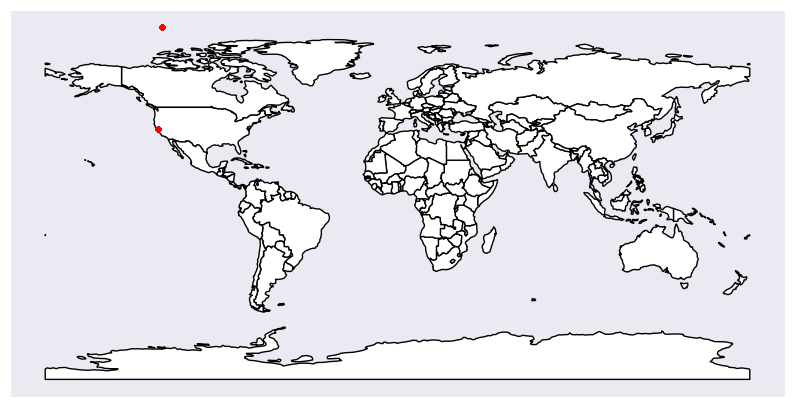

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns

def create_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y), crs='epsg:4326')
    return gdf


crime_gdf = create_gdf(crime)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(10, 10))

world.plot(ax=ax, color='white', edgecolor='black')
crime_gdf.plot(ax=ax, color='red', markersize=10)  # Adjust markersize as needed

ax.set_aspect('equal')

#sns.despine(ax=ax, left=True, right=True, top=True, bottom=True)

ax.set_xticks([])  # Use set_xticks to hide x-axis ticks
ax.set_yticks([])  # Use set_yticks to hide y-axis ticks


plt.show()


Ein Blick auf die Karte genügt um zu sehen, dass sich einige Punkte außerhalb der USA und außerhalb von San Fransisco befinden. Diese Punkte werden konkret lokalisiert und im nächsten Schritt ausgegeben. 

In [11]:
print(crime_gdf.loc[crime_gdf.Y > 50].count()[0])
crime_gdf.loc[crime_gdf.Y > 50].sample(5)

29


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CrimeId,YearMonth,YearMonthDay,MonthDay,Year,Month,Day,TimeOfDay,geometry
754828,2004-08-21 23:35:00,LARCENY/THEFT,ATTEMPTED THEFT FROM LOCKED VEHICLE,Saturday,SOUTHERN,NONE,BRANNAN ST / 1ST ST,-120.5,90.0,754828,2004-08,2004-08-21,08-21,2004,08,21,23,POINT (-120.50000 90.00000)
759397,2004-08-03 19:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,NORTHERN,NONE,LARKIN ST / AUSTIN ST,-120.5,90.0,759397,2004-08,2004-08-03,08-03,2004,08,03,19,POINT (-120.50000 90.00000)
660485,2005-12-30 17:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TENDERLOIN,NONE,5THSTNORTH ST / OFARRELL ST,-120.5,90.0,660485,2005-12,2005-12-30,12-30,2005,12,30,17,POINT (-120.50000 90.00000)
674043,2005-10-21 10:15:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,BRANNAN ST / 1ST ST,-120.5,90.0,674043,2005-10,2005-10-21,10-21,2005,10,21,10,POINT (-120.50000 90.00000)
677268,2005-10-06 17:30:00,VEHICLE THEFT,"VEHICLE, RECOVERED, AUTO",Thursday,RICHMOND,NONE,AVENUE OF THE PALMS / EUCLID AV,-120.5,90.0,677268,2005-10,2005-10-06,10-06,2005,10,06,17,POINT (-120.50000 90.00000)


Zusammengefasst gibt der Code also die Anzahl der Datensätze mit einer Y-Koordinate größer als 50 aus und zeigt dann fünf zufällige Datensätze mit dieser Bedingung an. Dies könnte darauf hindeuten, dass es im GeoDataFrame einige Datensätze mit ungewöhnlichen oder fehlerhaften geografischen Koordinaten gibt. Damit diese auffälligen Daten nicht aus der Analyse ausgeschlossen werden, können die Mittelwerte der vorhandenen Koordinaten der jeweiligen Polizeidistrikte genutzt werden.

In [12]:
crime.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in crime['PdDistrict'].unique():
    crime.loc[crime['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        crime.loc[crime['PdDistrict'] == district, ['X', 'Y']])

crime_gdf = create_gdf(crime)

Es wird folglich für jedes einzigartige Polizeidistrikt ('PdDistrict') im DataFrame crime der Imputer verwendet, um fehlende Werte in den Spalten 'X' und 'Y' durch den Mittelwert der vorhandenen Werte im jeweiligen Distrikt zu ersetzen.

## Fehlende Werte

In [13]:
crime.isnull().sum()

Dates           0
Category        0
Descript        0
DayOfWeek       0
PdDistrict      0
Resolution      0
Address         0
X               0
Y               0
CrimeId         0
YearMonth       0
YearMonthDay    0
MonthDay        0
Year            0
Month           0
Day             0
TimeOfDay       0
dtype: int64

In [14]:
if sum(crime.isnull().any()*1):
    print("Es gibt fehlende Daten.")
else:
    print("Es gibt keine fehlenden Daten")

Es gibt keine fehlenden Daten


Nachdem die Koordinaten bereinigt wurden, werden weitere fehlende Werte berücksichtigt. Dafür wird die obenstehende Funktion verwendet um die Anzahl der fehlenden Werte in jedem Attribut (Spalte) des DataFrames zu zählen.

Wie aus der Tabelle abgelesen werden kann, gibt es für alle Kategorien keine fehlenden Werte. 




# 5. Exploration

Nachdem die Datenbereinigung abgeschlossen wurde, wird nun der Fokus auf die Exploration der Daten gelegt. Hierbei handelt es sich um einen Prozess, bei dem der Datensatz analysiert wird, um ein besseres Verständnis für die enthaltenen Variablen zu entwickeln. Ziel ist es, Muster, Trends oder ungewöhnliche Beobachtungen zu identifizieren. Dieser Prozess hilft bei der Vorbereitung der Daten für die weitere Analyse und Modellbildung.

## Deskriptive Statistik

### Balkendiagramme

#### Verbrechen je Bezirk

In [15]:
data_cat = crime.groupby('Category').count().iloc[:, 0]. sort_values(ascending=False)
data = data_cat.reindex(np.append(np.delete(data_cat.index, 1), 'OTHER OFFENSES'))



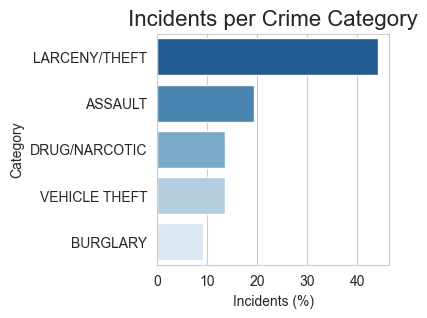

In [16]:
plt.figure(figsize=(3, 3))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        x = (data_cat.values / data_cat.values.sum()) * 100,
        y = data_cat.index,
        orient='h',
        palette="Blues_r")

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()

Für einen ersten Überblick werden Einzelfälle pro Kategorie in Prozent aufgeschlüsselt. Es ist deutlich zu erkennen, dass 'Larceny/Theft' nahezu 50 Prozent der Fälle ausmacht. Dahingegen werden nur knapp unter 10 Prozent der Fälle als 'Burglary' klassifiziert.'

In [17]:
data_cat.describe()

count         5.000000
mean      79256.600000
std       55335.524271
min       36755.000000
25%       53781.000000
50%       53971.000000
75%       76876.000000
max      174900.000000
Name: Dates, dtype: float64

Für die weitere Einordnung wird die Funktion describe() genutzt. Wie bereits in der Selektion deutlich wurde, wird in der Analyse nur mit den fünf ausgewählten Kategorien gearbeitet. Außerdem können einige grundlegende statistische Maße abgelesen werden.

### Histogramme

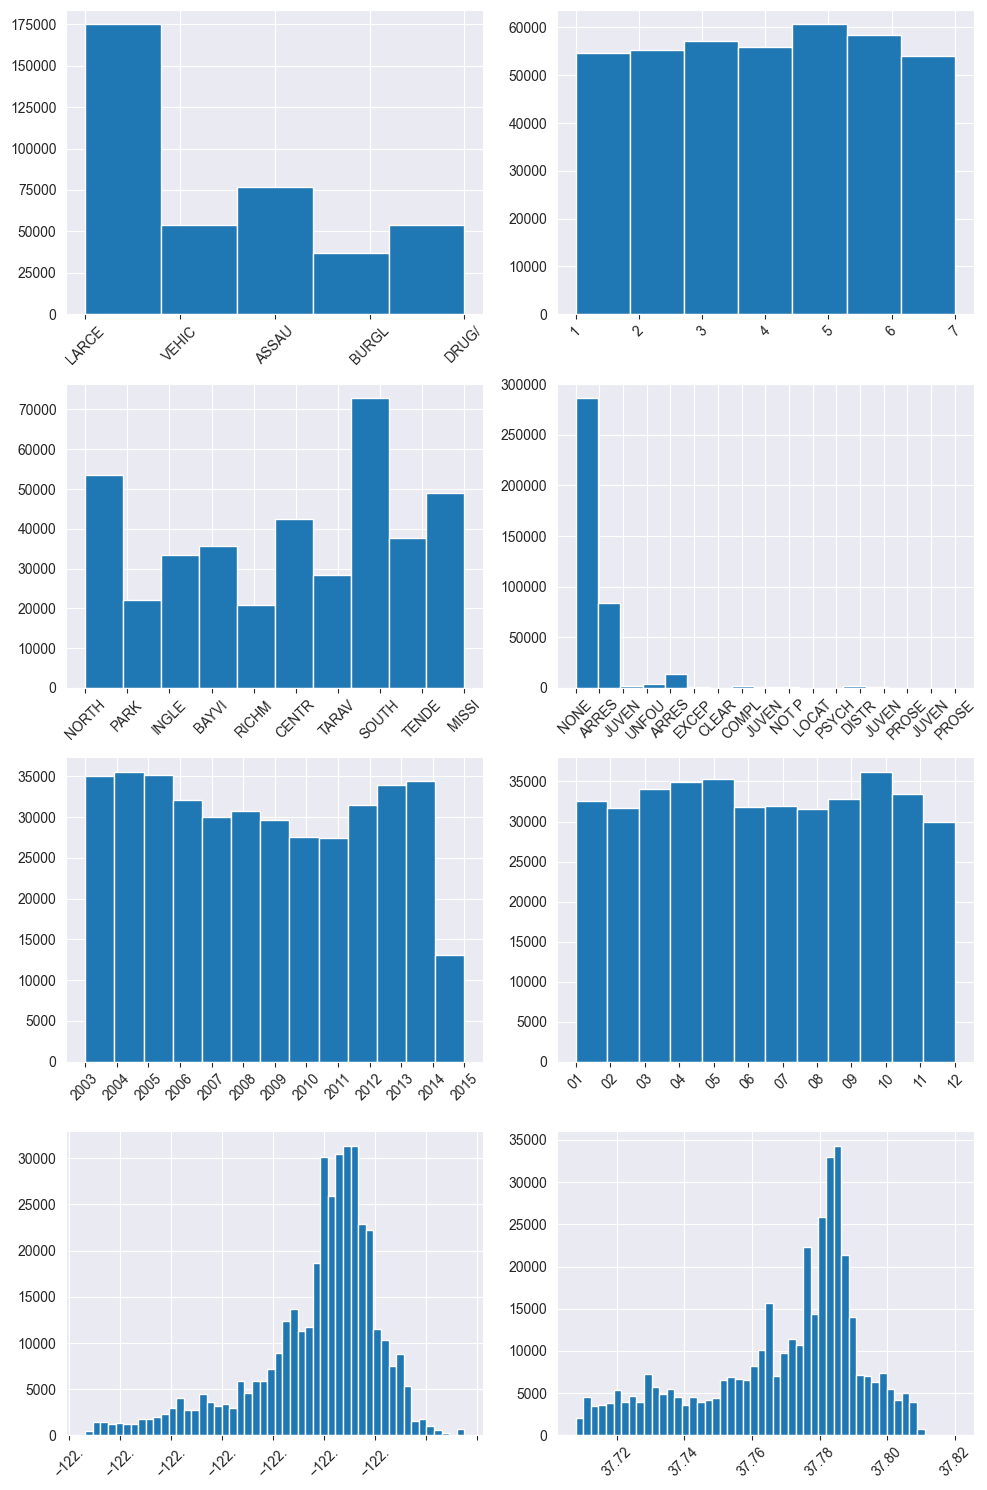

In [18]:


def truncate_label(label, length=5):
    return label[:length]

colors = sns.color_palette(None, 3)
columns = ["DayOfWeek", "PdDistrict", "Resolution"]


fig, axes = plt.subplots(4, 2, figsize = (10, 15), tight_layout=True)

axes[0, 0].hist(crime["Category"], bins=5, align="mid")

#Tag der Woche als Zahl für Sortierung der Balken
axes[0, 1].hist(crime['Dates'].dt.weekday + 1, bins=7, align="mid")

axes[1, 0].hist(crime["PdDistrict"], bins=len(crime["PdDistrict"].unique()))
axes[1, 1].hist(crime["Resolution"], bins=len(crime["Resolution"].unique()))
axes[2, 0].hist(crime["Year"].sort_values(), bins=13)
axes[2, 1].hist(crime["Month"].sort_values(), bins=12)
axes[3, 0].hist(crime["X"], bins=50)
axes[3, 1].hist(crime["Y"], bins=50)

# Rotate x-axis tick labels
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_ticks_position('bottom')  # Place ticks at the bottom for better visibility
    ax.set_xticklabels([truncate_label(label.get_text()) for label in ax.get_xticklabels()])

plt.tight_layout()

plt.show()

Hier werden Histogramme für verschiedene Merkmale des Kriminalitätsdatensatzes erstellt, einschließlich der Kategorie der Straftaten, dem Wochentag, dem Polizeibezirk, der Auflösung, dem Jahr, dem Monat sowie den geografischen Koordinaten X und Y. 

### Zeitliche Regression

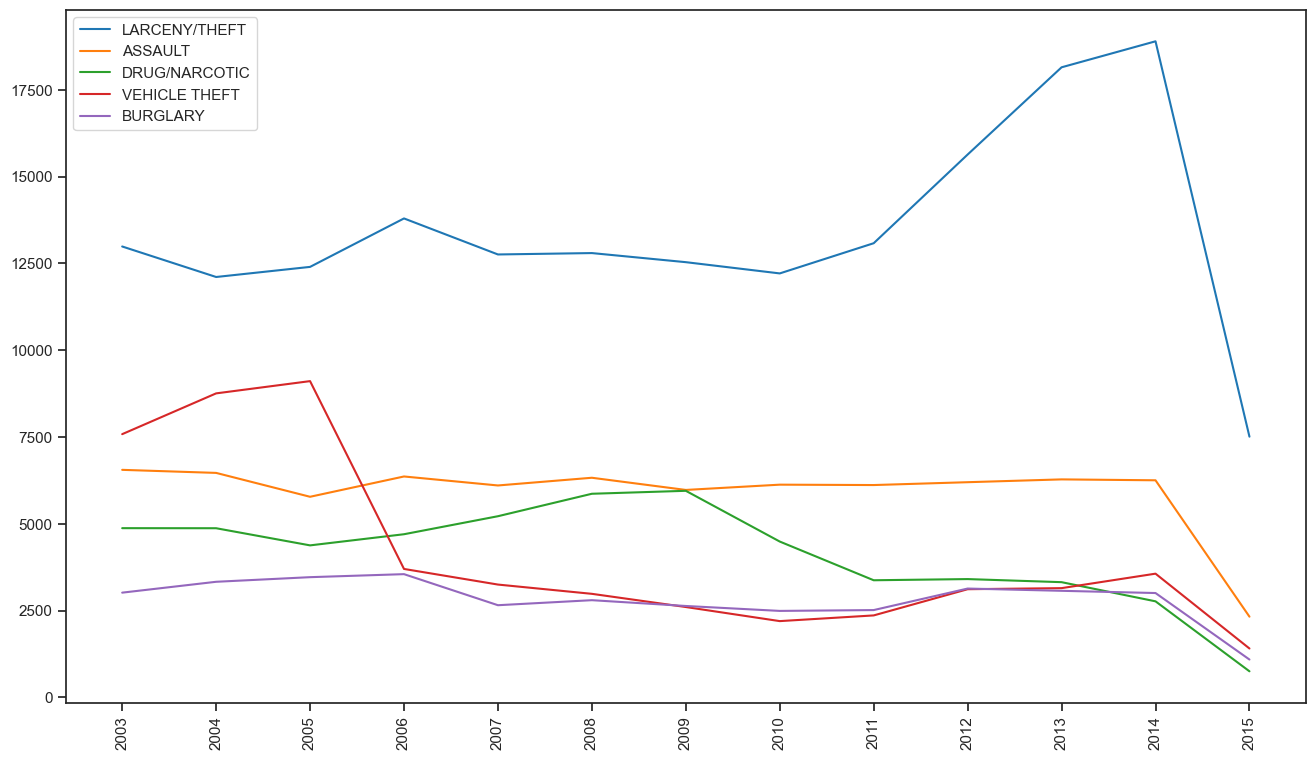

In [19]:
sns.set_style("ticks")
sns.set_context('notebook', font_scale = 1)

crime_year_cat = crime.groupby(by=["Year", "Category"], as_index=False).count()
data = crime_year_cat.pivot_table(index="Year", columns="Category", values="Descript")

fig = plt.figure(figsize=(16,9))

for category in categories:
    plt.plot(data[category], label=category)

plt.legend(loc="upper left")
tix = plt.xticks()[0]
plt.xticks(tix, rotation=90, ha="center")
plt.show()


Es folgt eine Visualising der zeitlichen Regression und Entwicklung der Straftaten in verschiedenen Kategorien über die Jahre gruppiert nach 'Year', wodurch Trends und Muster im zeitlichen Verlauf sichtbar werden. Besonders Auffällig ist der Abfall von 'Larceny/Theft' nach dem Jahr 2014. 

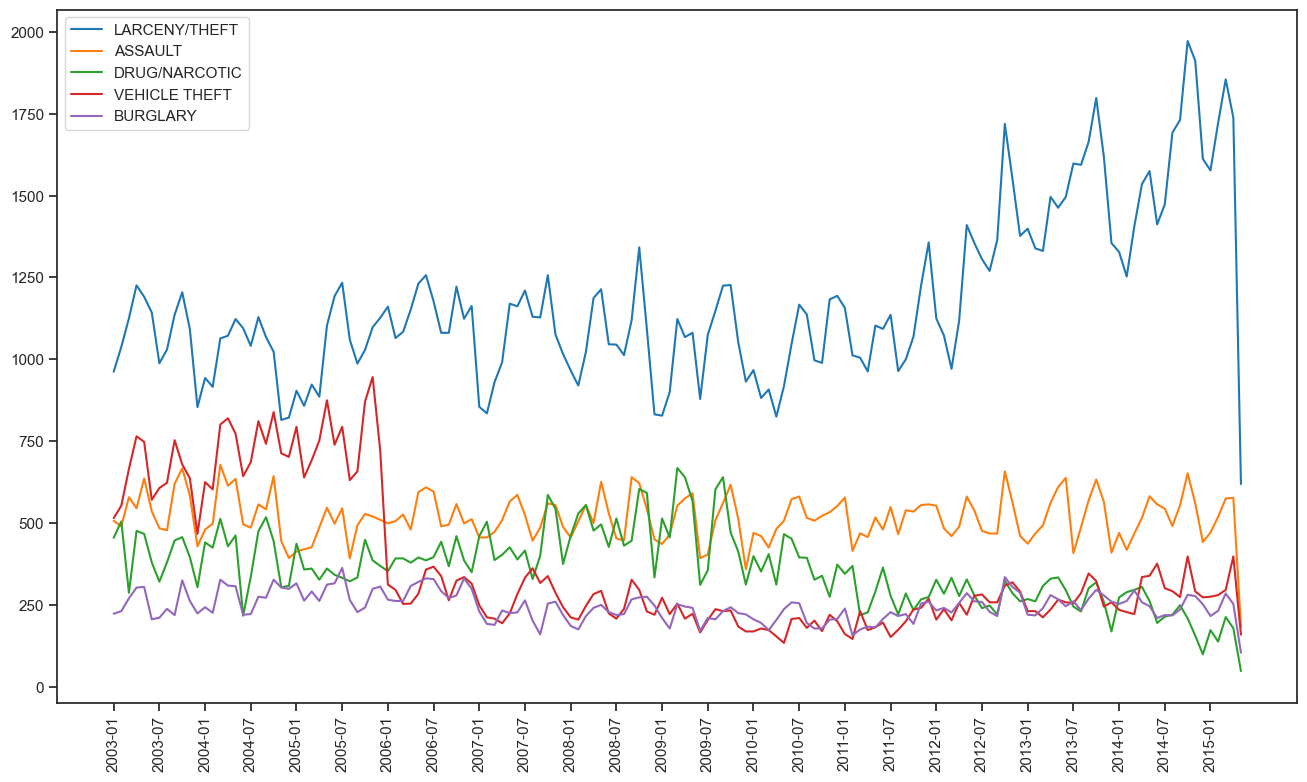

In [20]:
crime_yearmonth_cat = crime.groupby(by=["YearMonth", "Category"], as_index=False).count()
data = crime_yearmonth_cat.pivot_table(index="YearMonth", columns="Category", values="Descript")

fig = plt.figure(figsize=(16,9))

for category in categories:
    plt.plot(data[category], label=category)

plt.legend(loc="upper left")
tix = plt.xticks()[0]
plt.xticks(tix[::6], rotation=90, ha="center")
plt.show()

Diese Visualisierung zeigt ebenfalls die zeitliche Entwicklung der Straftaten nach den jeweiligen Kategorien. In diesem Fall wird jedoch eine Gruppierung nach 'YearMonth' vorgenommen, damit eine feinere zeitliche Auflösung ersichtlich wird. 

### Kartogramme

In [21]:

sf_df = gpd.read_file("data/SF Find Neighborhoods.geojson").to_crs({'init': 'epsg:4326'})

geometry = [Point(xy) for xy in zip(crime.X, crime.Y)]
crime_gdf = GeoDataFrame(crime, crs="EPSG:4326", geometry=geometry)


point = crime_gdf
poly  = sf_df

pointInPolys = sjoin(point, poly, how='left')
pointInPolys.drop_duplicates(subset=['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
                                     'Resolution', 'Address', 'X', 'Y', 'YearMonth', 'Year', 'Month', 'Day',
                                     'TimeOfDay'], inplace=True)

pointInPolys = pointInPolys.rename(columns ={"name" : "crdistrict"})

crime = crime.join(pointInPolys[["CrimeId", "crdistrict"]], on="CrimeId", lsuffix="_")

grouped = pointInPolys.groupby('index_right').count()


Hier wird eine GeoDataFrame (sf_df) aus einer GeoJSON-Datei eingelesen, die die Grenzen der Stadtviertel von San Francisco enthält. Die to_crs-Methode wird verwendet, um die Koordinatenreferenz des GeoDataFrames auf das Standardformat (EPSG:4326) zu ändern, das Längen- und Breitengrade verwendet. 
Vgl. City and County of San Francisco. (2016). SF Find Neighborhoods. [Dataset]. Socrata. https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4

Insgesamt ermöglicht dieses Vorgehen die Zuordnung von Kriminalitätsdaten zu den entsprechenden Stadtvierteln von San Francisco und die Berechnung der Anzahl der Vorkommen in jedem Viertel. Dies ist nützlich, um räumliche Muster und Hotspots von Kriminalität zu identifizieren.

In [22]:
heat_districts = pointInPolys.groupby(['index_right', 'crdistrict'])["Dates"].count()
heat_districts

index_right  crdistrict            
0.0          Seacliff                   239
1.0          Lake Street                450
2.0          Presidio National Park      36
3.0          Presidio Terrace           465
4.0          Inner Richmond            4975
                                       ... 
112.0        Corona Heights             579
113.0        Ashbury Heights            591
114.0        Eureka Valley             1664
115.0        St. Francis Wood           226
116.0        Sherwood Forest            191
Name: Dates, Length: 117, dtype: int64

In heat_districts werden dafür Indexwerte für die einzelnen Stadtviertel erstellt. Die Werte repräsentieren dabei die Anzahl der Kriminalitätsvorfälle in jedem Stadtviertel.

In [23]:

geom = sf_df.pop('geometry')
sf_df = sf_df.join(geom, how='inner')
sf_df["polygons"] = ""
for i,row in sf_df.iterrows():
    geometry = row["geometry"]
    if geometry.geom_type == 'MultiPolygon':
        polygons = []
        for polygon in geometry.geoms:
            exterior_coords = list(polygon.exterior.coords)
            interior_coords = [list(interior.coords) for interior in polygon.interiors]
            polygons.append(Polygon(exterior_coords, interior_coords))
    else:
        polygons = [Polygon(list(geometry.exterior.coords))]
    sf_df.at[i, "polygons"] = polygons

sf_df["polygons"] = sf_df["polygons"].explode()

sf_df["index_right"] = sf_df.index
sf_df["heat"] = sf_df.merge(heat_districts, on="index_right")["Dates"]
sf_df["geometry"] = sf_df["polygons"]

gdf = gpd.GeoDataFrame(sf_df)




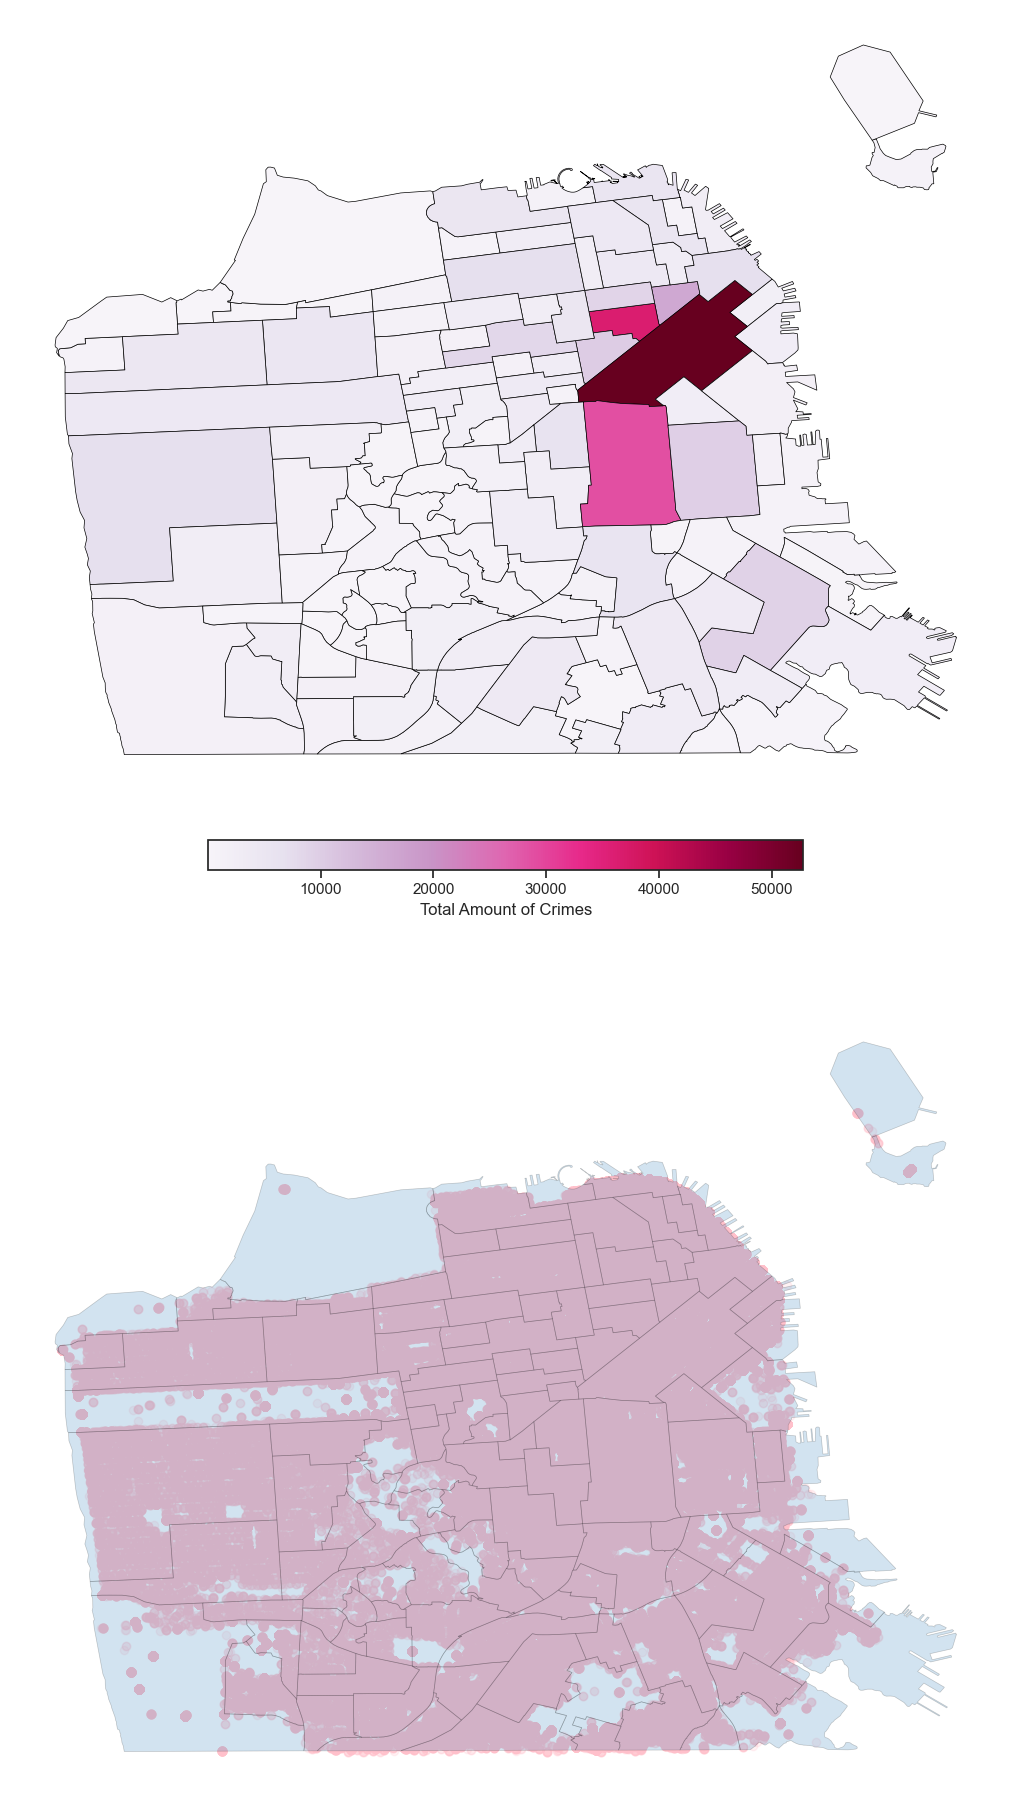

In [24]:
fig, ax = plt.subplots(2,1,figsize=(10, 20), layout='constrained')

gdf.plot(ax=ax[0], alpha=1, edgecolor='k', linewidth=0.5, column="heat", cmap="PuRd")
cbar = plt.colorbar(ax[0].get_children()[0], ax=ax[0], orientation="horizontal", shrink=0.6)
cbar.set_label("Total Amount of Crimes")

sf_df = gpd.read_file("data/SF Find Neighborhoods.geojson").to_crs({'init': 'epsg:4326'})
sf_df.plot(ax=ax[1], alpha=0.2, edgecolor='k', linewidth=0.5, zorder=2)
ax[1].scatter(data=crime.loc[crime["Y"]<80], x="X", y="Y",alpha=0.2, color="pink", zorder=1)

ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')

sns.despine(ax=ax[0], left=True, right=True, top=True, bottom=True)
sns.despine(ax=ax[1], left=True, right=True, top=True, bottom=True)

ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])

ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])    
    
plt.show()



Insgesamt kann in der Heat-Map ein deutliches Muster erkannt werden. Die Kriminalfälle bündeln sich besonders in den Stadtvierteln im Nord-Osten von San Francisco.

## Feature Engineering

An dieser Stelle werden neue Spalten generiert, die den Datensatz bereichern und den Modellen helfen können.

### Feiertage

Zuerst werden die US-Feiertage importiert und dem Datensatz hinzugefügt.

In [25]:
import holidays

usa_holidays = pd.Series(holidays.country_holidays('US',  years=range(crime["Dates"].dt.year.min(), crime["Dates"].dt.year.max())))

usa_holidays = pd.DataFrame(usa_holidays)
usa_holidays.columns = ["Holiday"]
usa_holidays["YearMonthDay"] = pd.to_datetime(usa_holidays.index)
usa_holidays.reset_index(drop=True)

crime["YearMonthDay"] = pd.to_datetime(crime["YearMonthDay"])
crime = crime.merge(usa_holidays, on="YearMonthDay", how="left")

crime["Holiday"].fillna("None", inplace=True)

In [26]:
crime.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CrimeId_,YearMonth,YearMonthDay,MonthDay,Year,Month,Day,TimeOfDay,CrimeId,crdistrict,Holiday
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,3,2015-05,2015-05-13,05-13,2015,05,13,23,3.0,Union Street,None
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,4,2015-05,2015-05-13,05-13,2015,05,13,23,4.0,Buena Vista,None
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,5,2015-05,2015-05-13,05-13,2015,05,13,23,5.0,Visitacion Valley,None
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,6,2015-05,2015-05-13,05-13,2015,05,13,23,6.0,Excelsior,None
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,7,2015-05,2015-05-13,05-13,2015,05,13,23,7.0,Hunters Point,None


In [27]:
df_district_holiday = pd.crosstab(crime['Category'], crime['Holiday'])
df_district_holiday = df_district_holiday.loc[:, df_district_holiday.columns != 'None']
df_district_holiday.head()

Holiday,Christmas Day,Christmas Day (Observed),Columbus Day,Independence Day,Independence Day (Observed),Labor Day,Martin Luther King Jr. Day,Memorial Day,New Year's Day,New Year's Day (Observed),Thanksgiving,Veterans Day,Veterans Day (Observed),Washington's Birthday
Category,,,,,,,,,,,,,,
ASSAULT,201,86,185,42,44,388,179,378,198,37,172,191,52,335
BURGLARY,117,47,112,16,13,102,92,151,45,10,98,80,34,166
DRUG/NARCOTIC,65,32,166,11,13,272,202,271,54,13,86,176,43,315
LARCENY/THEFT,368,183,516,57,63,729,461,688,241,76,319,463,157,756
VEHICLE THEFT,153,90,148,17,42,218,133,217,43,14,111,159,32,250


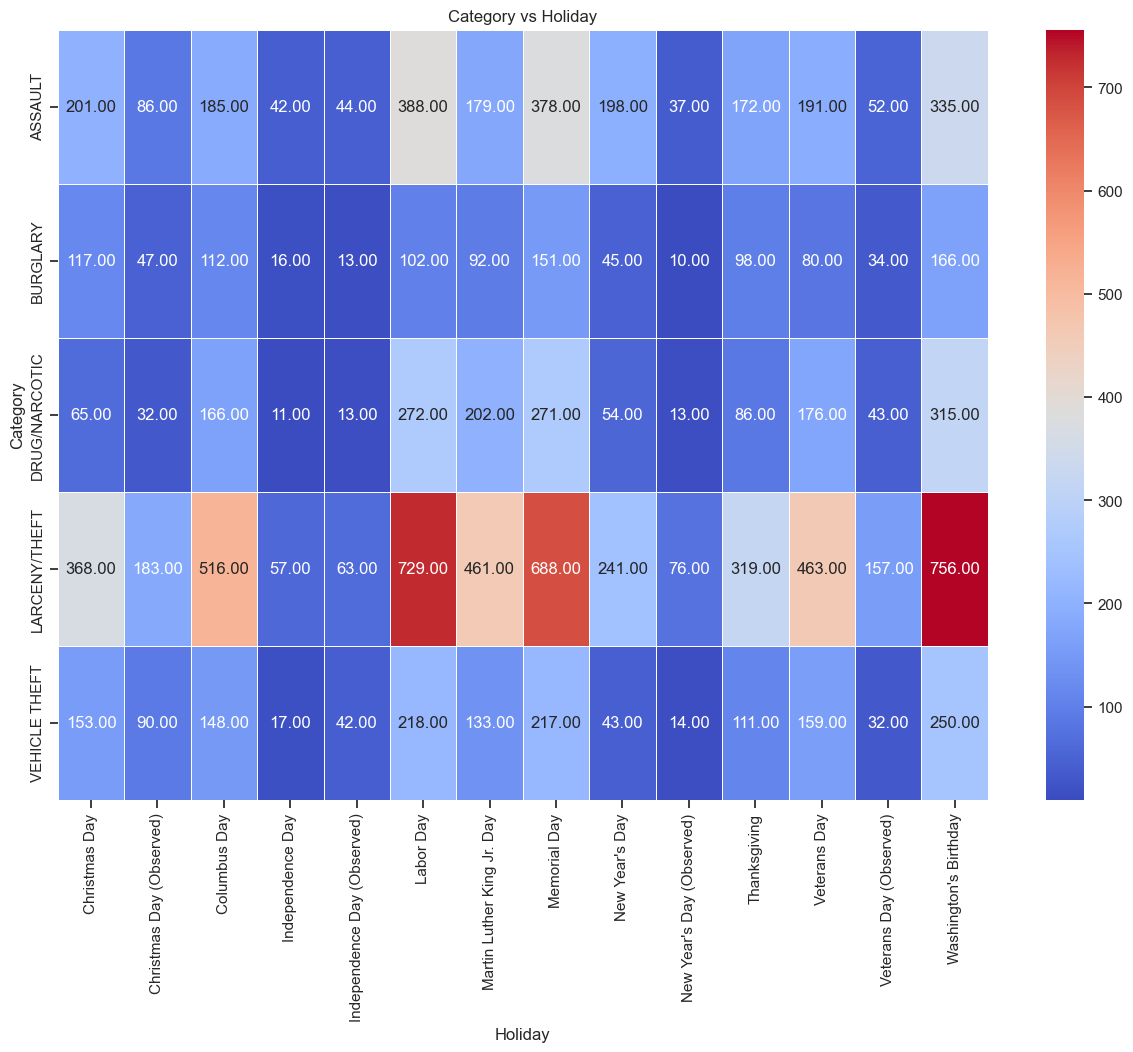

In [28]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_district_holiday, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Category vs Holiday')
plt.show()

In dieser Heat-Map werden die Feiertage den Kriminalkategorien entgegengestellt. Hier lässt sich ablesen, dass es die meisten Verbechen am Labor Day und Washingtons Birthday gibt.

### Wetter

Die Daten werden um ein weiteres Feature erweitert. Heirfür werden die Wetterdaten für die entsprechende Region importiert.

In [29]:
crime.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CrimeId_,YearMonth,YearMonthDay,MonthDay,Year,Month,Day,TimeOfDay,CrimeId,crdistrict,Holiday
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,3,2015-05,2015-05-13,05-13,2015,05,13,23,3.0,Union Street,None
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,4,2015-05,2015-05-13,05-13,2015,05,13,23,4.0,Buena Vista,None
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,5,2015-05,2015-05-13,05-13,2015,05,13,23,5.0,Visitacion Valley,None
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,6,2015-05,2015-05-13,05-13,2015,05,13,23,6.0,Excelsior,None
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,7,2015-05,2015-05-13,05-13,2015,05,13,23,7.0,Hunters Point,None


In [30]:
crime["hours"] = pd.to_datetime(crime['Dates'].dt.strftime('%Y-%m-%d %H'))

In [31]:
from meteostat import Point, Hourly
import pandas as pd
import matplotlib.pyplot as plt

start_date = crime['Dates'].min()
end_date = crime['Dates'].max()

san_francisco = Point(37.7749, -122.4194, 10)

# Get hourly data for the specified date range
sf_weather = pd.DataFrame(Hourly(san_francisco, start_date, end_date).fetch())

sf_weather["hours"] = pd.to_datetime(sf_weather.index.strftime('%Y-%m-%d %H'))
crime = crime.merge(sf_weather, how="left", on="hours")

In [32]:
crime.describe()

,Dates,X,Y,CrimeId_,YearMonthDay,CrimeId,hours,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
count,396283,396283.000000,396283.000000,396283.000000,396283,395360.000000,396283,396277.000000,396277.000000,396277.000000,391924.00000,0.0,379557.000000,396277.000000,0.0,396277.000000,0.0,0.0
mean,2009-02-11 01:12:43.027432448,-122.422923,37.768880,445289.694544,2009-02-10 10:56:42.750054912,445432.070225,2009-02-11 00:54:13.420409088,14.355910,9.081409,72.990264,0.05265,NaN,229.170006,12.870807,NaN,1017.067608,NaN,NaN
min,2003-01-06 00:01:00,-122.513642,37.707920,3.000000,2003-01-06 00:00:00,3.000000,2003-01-06 00:00:00,-1.700000,-15.800000,8.000000,0.00000,NaN,10.000000,0.000000,NaN,995.700000,NaN,NaN
25%,2005-10-23 13:45:00,-122.433010,37.755504,216823.000000,2005-10-23 00:00:00,216969.750000,2005-10-23 13:30:00,11.700000,6.800000,63.000000,0.00000,NaN,180.000000,7.600000,NaN,1013.900000,NaN,NaN
50%,2008-12-26 12:00:00,-122.416642,37.776044,452744.000000,2008-12-26 00:00:00,453025.500000,2008-12-26 12:00:00,14.000000,9.900000,75.000000,0.00000,NaN,260.000000,11.200000,NaN,1016.700000,NaN,NaN
75%,2012-06-26 04:59:00,-122.407149,37.785103,673192.500000,2012-06-26 00:00:00,673364.750000,2012-06-26 04:30:00,17.200000,12.000000,86.000000,0.00000,NaN,290.000000,18.400000,NaN,1020.000000,NaN,NaN
max,2015-05-13 23:30:00,-122.364937,37.819975,878046.000000,2015-05-13 00:00:00,878046.000000,2015-05-13 23:00:00,36.700000,21.100000,100.000000,14.20000,NaN,360.000000,64.800000,NaN,1034.800000,NaN,NaN
std,NaN,0.025090,0.023801,257587.552855,NaN,257604.598322,NaN,4.610553,4.073596,16.489246,0.38607,NaN,86.088357,9.063533,NaN,4.664577,NaN,NaN


<Axes: xlabel='temp'>

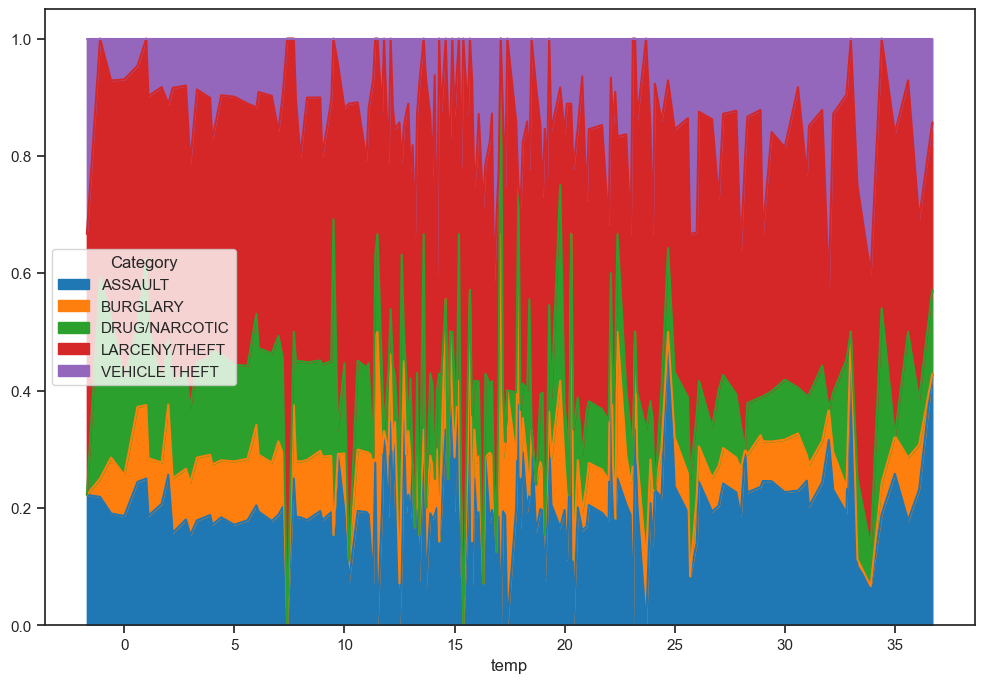

In [33]:
temp_cat_ct = pd.crosstab(crime["temp"], crime["Category"],  normalize='index')
temp_cat_ct.plot(kind="area",  stacked="true", figsize=(12, 8))

### Straßen

Außerdem werden Straßen dem Datensatz hinzugefügt. Ziel ist es eine Übersicht der *gefährlichsten* Straßen in San Francisco zu bekommen.

In [34]:
is_block = crime["Address"].str.contains(" /")
crime.loc[is_block, "Street/Block"] = crime.loc[is_block, "Address"].copy()
crime.loc[is_block, "Street_1"] = crime.loc[is_block, "Address"].apply(lambda x: x.split(" /")[0]).copy()
crime.loc[is_block, "Street_2"] = crime.loc[is_block, "Address"].apply(lambda x: x.split(" /")[1]).copy()

is_street = crime["Address"].str.contains(" of ")
crime.loc[is_street, "Street/Block"] = crime.loc[is_street, "Address"].apply(lambda x: x.split(" of ")[1]).copy()
crime.loc[is_street, "Street_1"] = crime.loc[is_street, "Address"].apply(lambda x: x.split(" of ")[1]).copy()
crime.loc[is_street, "Street_2"] = None
crime.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CrimeId_,...,snow,wdir,wspd,wpgt,pres,tsun,coco,Street/Block,Street_1,Street_2
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,3,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,LOMBARD ST,LOMBARD ST,None
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,4,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,BRODERICK ST,BRODERICK ST,None
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,5,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,TEDDY AV,TEDDY AV,None
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,6,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,AVALON AV / PERU AV,AVALON AV,PERU AV
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,7,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,KIRKWOOD AV / DONAHUE ST,KIRKWOOD AV,DONAHUE ST


In [35]:
str_cat_ct = pd.crosstab(crime["Street/Block"], crime["Category"], margins=True, margins_name="Total")

str_cat_ct = str_cat_ct[str_cat_ct.index != "Total"]
top_ten_str = str_cat_ct.sort_values(by="Total", ascending=False).head(10)
top_ten_str

Category,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,VEHICLE THEFT,Total
Street/Block,,,,,,
MARKET ST,2192,1254,2270,7675,197,13588
MISSION ST,2934,857,3063,3874,493,11221
BRYANT ST,2087,557,822,6737,317,10520
TURK ST,1181,266,2428,660,154,4689
OFARRELL ST,821,499,725,2387,250,4682
ELLIS ST,1028,233,1909,737,143,4050
EDDY ST,1380,329,1018,803,142,3672
POST ST,408,419,216,1796,162,3001
POWELL ST,470,264,114,2078,61,2987


Anhand der Tabelle wird deutlich, dass bei den Top drei der gefährlichsten Straßen mit den meisten Kriminalfällen um die Market St, Mission St und Bryant St handelt. Hierbei ist jedoch die Länge der Straße zu beachten, damit diese Werte in ein geeignetes Verhältnis gesetzt werden können. Einige Straßen reichen durch nahezu die komplette Stadt, während andere kurz bemessen sind.

Zuletzt folgt die Visualisierung der Straßen anhand von einem Balkendiagramm.

<Axes: xlabel='Street/Block'>

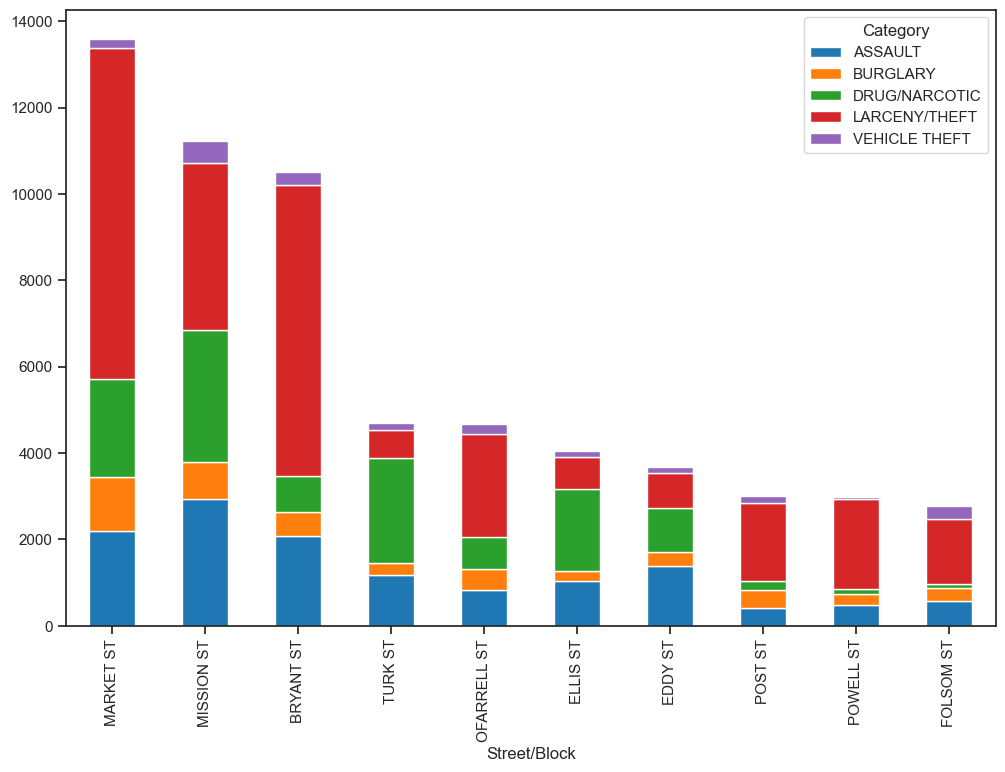

In [36]:
top_ten_str.drop('Total', axis=1).plot(kind='bar', stacked=True, figsize=(12, 8))

### Korrelation

Nachfolgend werden weitere Korrelationen berechent und visualisiert, um erneut Muster und Zusammenhänge in den Daten zu erkennen.

#### Korrelation zwischen Kategorien und Bezirken

Dafür wird im ersten Schritt eine Kreuztabelle für den Bezirk und die Kategorie erstellt.

In [37]:
df_district_cat = pd.crosstab(crime['Category'], crime['PdDistrict'])
df_district_cat.head()

PdDistrict,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
Category,,,,,,,,,,
ASSAULT,9857,6977,8533,11149,8318,3515,3202,12183,5463,7679
BURGLARY,3930,4519,3331,3745,5854,2888,2696,4841,3463,1488
DRUG/NARCOTIC,4498,1805,2373,8757,4511,2573,999,9228,1531,17696
LARCENY/THEFT,10119,25060,10236,18223,28630,9146,9893,41845,11845,9903
VEHICLE THEFT,7219,4210,8960,7148,6291,3963,4117,4725,6142,1006


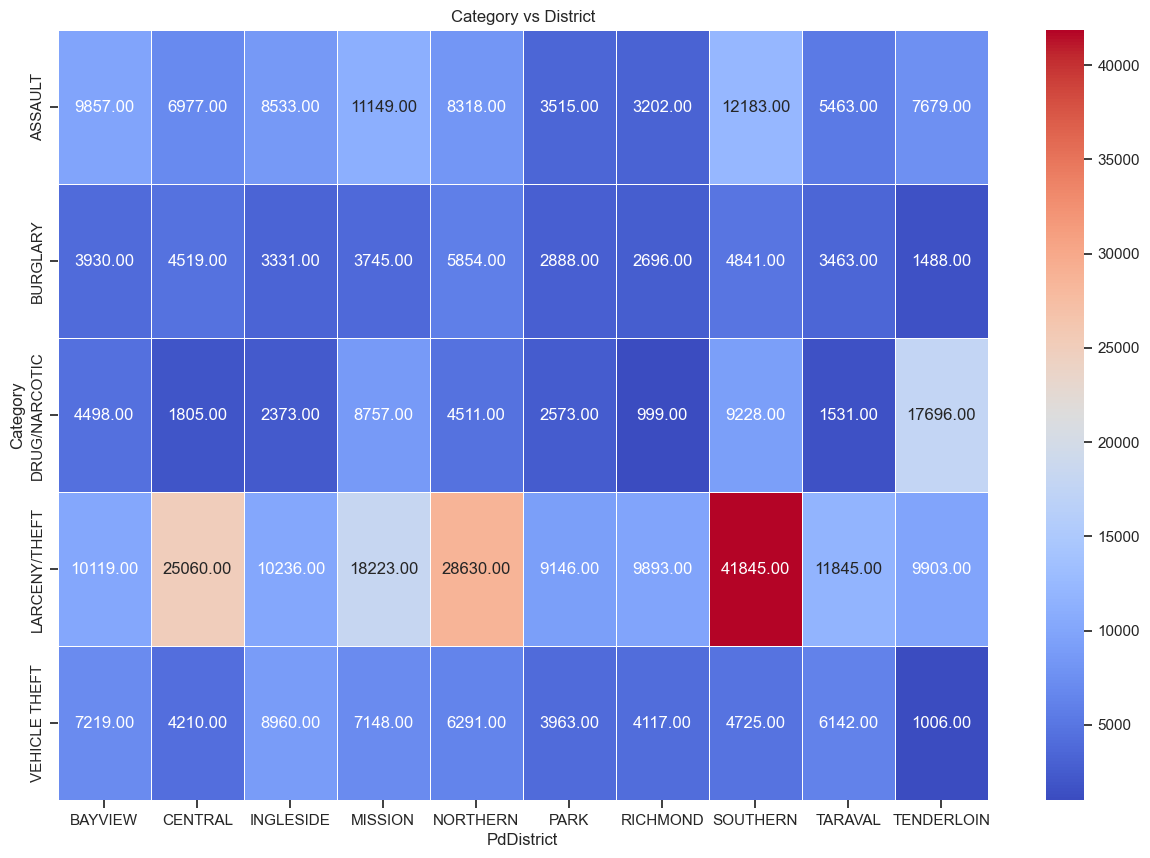

In [38]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_district_cat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Category vs District')
plt.show()

Anhand dieser Heat-Map wird ersichtlich, dass es besonders im Bezitk 'Southern' ein hohes Aufkommen von 'Larceny/Theft'-Kriminalfällen gibt.

#### Korrelation zwischen den kategorischen Spalten

Für die weitere Betrachtung wird die Korrelation zwischen den kategorischen Spalten betrachtet.

In [39]:
unique_val_col = pd.DataFrame(crime.nunique())
corr_columns = list(unique_val_col.loc[(unique_val_col[0] > 0) & (unique_val_col[0] <= 2500)].index)
print(corr_columns)

['Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'YearMonth', 'YearMonthDay', 'MonthDay', 'Year', 'Month', 'Day', 'TimeOfDay', 'crdistrict', 'Holiday', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'Street_1', 'Street_2']


In [40]:

x = [i[0] for i in product(corr_columns, corr_columns)]
y = [i[1] for i in product(corr_columns, corr_columns)]


corr_df = pd.DataFrame(index=corr_columns, columns=corr_columns)

for i in range(0,len(x)):
    if x[i] == y[i]:
        corr_df.loc[x[i], y[i]] = 1
        corr_df.loc[y[i], x[i]] = 1
    if pd.isnull(corr_df.loc[x[i], y[i]]):
        temp_ct = pd.crosstab(crime[x[i]], crime[y[i]])

        X2 = stats.chi2_contingency (temp_ct, correction= False )[0]
        n = sum(temp_ct.sum())
        minDim = min( temp_ct.shape )-1

        V = np.sqrt((X2/n) / minDim)

        corr_df.loc[x[i], y[i]] = V
        corr_df.loc[y[i], x[i]] = corr_df.loc[x[i], y[i]]

Hierfür wurde die Berechnung von Cramers-V genutzt.

Vgl. Cramér, H. (1946). Mathematical Methods of Statistics. Princeton: Princeton University Press, p. 282 (Chapter 21. The two-dimensional case). ISBN 0-691-08004-6.

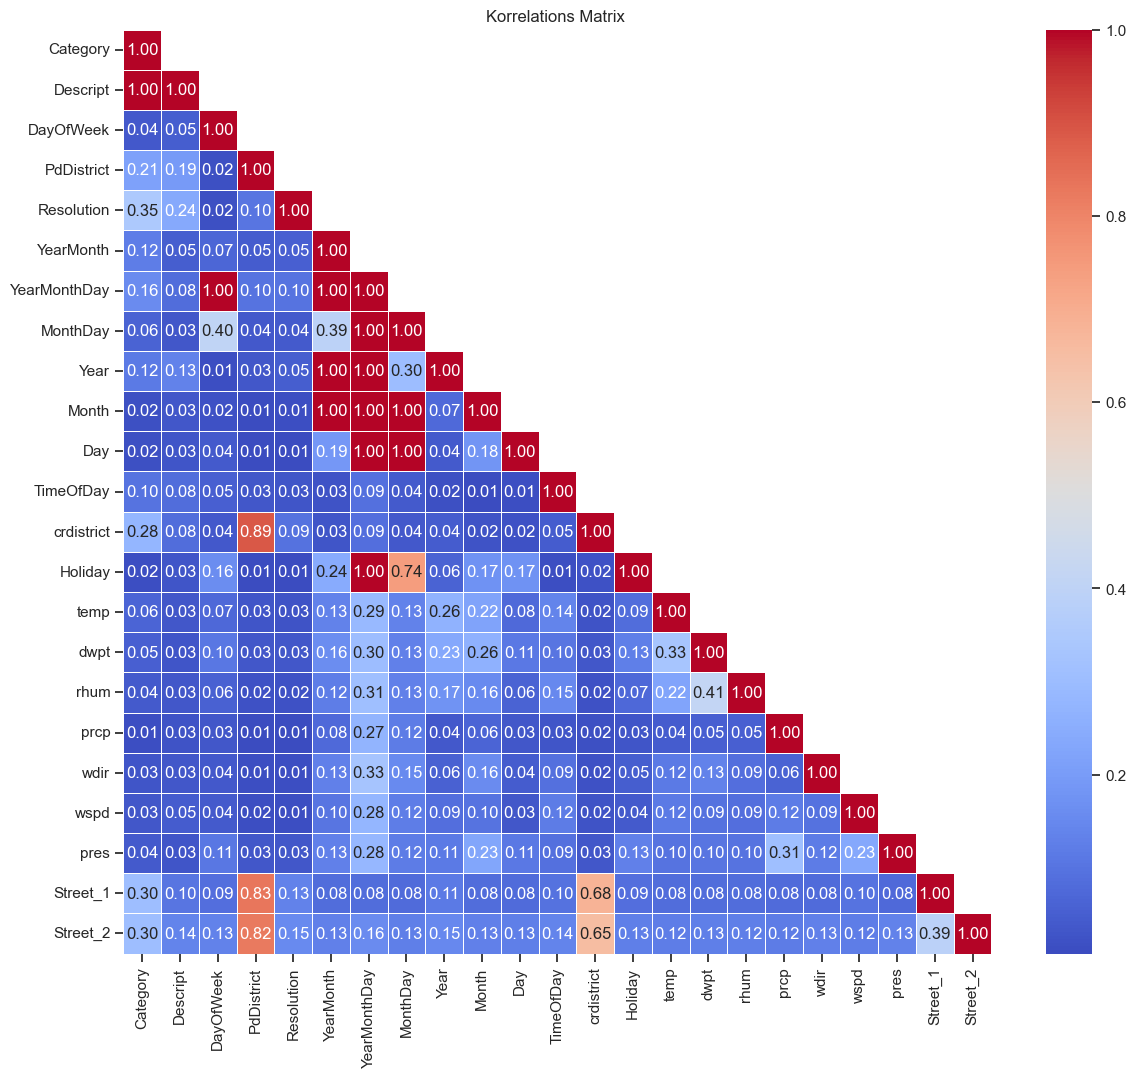

In [41]:
corr_df = corr_df.apply(pd.to_numeric, errors='coerce')

mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(14, 12))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Korrelations Matrix ')
plt.show()

Anhand der Korrelationsmatrix können verschiedene Trends abgelesen werden. Dies wird die Entscheidungsgrundlage für die weitere Bearbeitung der Daten sein. Für die Betrachtung der Daten werden wir im Folgenden nur Features auswählen, die eine Korrelation größer/gleich 0.09 mit Category vorweisen können.

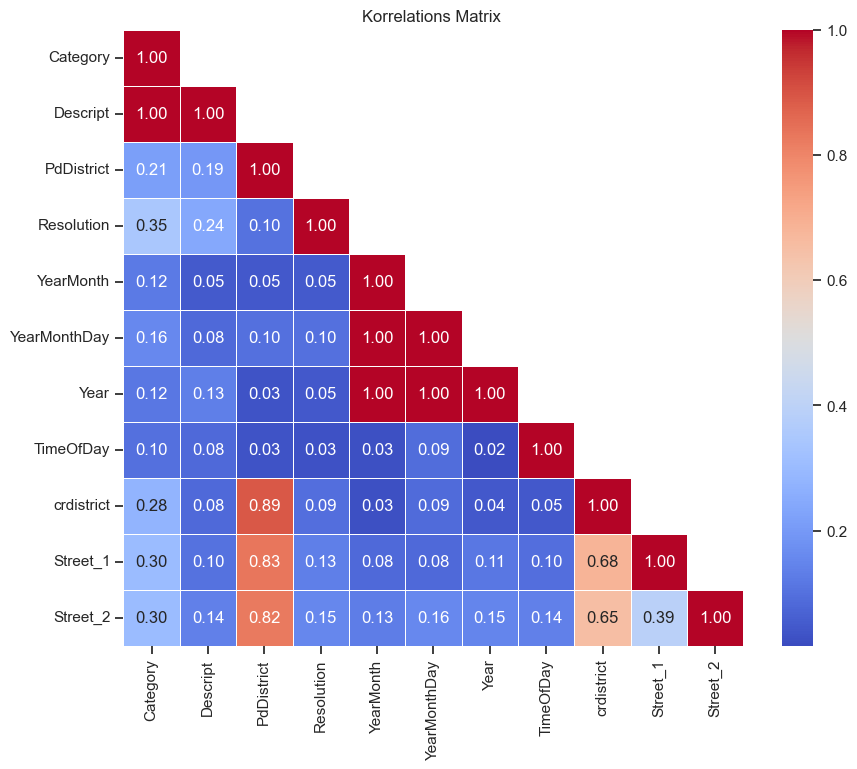

In [42]:
__corr_df = corr_df.loc[corr_df["Category"] >= 0.09]
#__corr_df = __corr_df.drop(["YearMonth", "Year", "Street_2"])
__corr_df = __corr_df.apply(pd.to_numeric, errors='coerce')
__corr_df = __corr_df[__corr_df.index]

mask = np.zeros_like(__corr_df)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(10, 8))
sns.heatmap(__corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Korrelations Matrix ')
plt.show()

Insgesamt ermöglicht diese Heatmap eine visuelle Darstellung der Korrelationsmatrix. Durch die Farben und die annotierten Werte können leicht Muster und Stärke der Korrelationen zwischen den verschiedenen Variablen im Datensatz erkannt werden. Besonders auffällig sind die vergleichsweise starken Korrelationen vom Verbrechensdistrik und den hinzugefügten Features Street_1 und Street_2. Die Resolution zeigt die größte Korrelation mit Category auf. Da die Resolution jedoch im Prinzip das Ergebnis "vorhersagt" wird dieses Feature nicht näher betrachtet. Das Ziel ist eine Vorhersage ohne die Berücksichtigung der Resolution. 

# 6. Vorbereitung

Anhand der Korrelation können wir ablesen, welche Spalten den größten Einfluss auf die Kategorie hat, welche wir letztendlich vorhersagen wollen.

In [43]:
__corr_df["Category"]


Category        1.000000
Descript        1.000000
PdDistrict      0.213993
Resolution      0.346091
YearMonth       0.123561
YearMonthDay    0.158514
Year            0.115952
TimeOfDay       0.099248
crdistrict      0.277125
Street_1        0.302480
Street_2        0.302578
Name: Category, dtype: float64

Im nächsten Schritt werden die Spalten ausgewählt, welche mindestens eine Korrelation von 0.05 haben.


Da Year und YearMonth fast die gleiche Korrelation mit Category haben und untereinander eine sehr hohe Korrelation haben, 
beschränken wir uns auf YearMonth und filtern Year raus. 

<!-- Resolution ist leider nicht in den Test-Daten vorhanden, daher nützt es nichts die Modelle mit dieser Spalte zu trainieren und sie wird ebenfalls entfernt.  -->

Und da wir Category vorhersagen sollen, wird es auch im Training nicht berücksichtigt.

In [44]:
onehot_cols = __corr_df.index


#Obwohl Resolution für die Kaggle-Challange nicht verwendet werden darf, darf es im Rahmen des Projekts zur Klassifikation dienen.
#onehot_cols.remove("Resolution")


onehot_cols = onehot_cols.drop(["Resolution", "Category", "Descript", "YearMonth", 'YearMonthDay', "Year", "Street_2"])
onehot_cols

Index(['PdDistrict', 'TimeOfDay', 'crdistrict', 'Street_1'], dtype='object')

Dadurch erhalten wir unsere finale Indexliste mit den ausgewählten Features. Diese werden zunächst dem One-Hot-Encoding unterzogen, um die kategorialen Variablen in einem numerischen Format darzustellen, damit diese zu einem späteren Zeitpunkt für die Modelle genutzt werden können. Hierfür wird die Funktion pd.get_dummies() aus der Pandas-Bibliothek genutzt. Als Ergebnis erhalten wir einen DataFrame. 

## One-Hot-Encoding

In [45]:
crime_dummies = pd.get_dummies(data=crime, columns=onehot_cols, dtype=float, prefix=["_" + i for i in onehot_cols])
crime_dummies = crime_dummies.drop(["CrimeId_", "Street_2"], axis=1)
crime_dummies["Category"] = crime["Category"]
crime_dummies.head()

,Dates,Category,Descript,DayOfWeek,Resolution,Address,X,Y,YearMonth,YearMonthDay,...,_Street_1_YORBA ST,_Street_1_YORK ST,_Street_1_YOSEMITE AV,_Street_1_YOUNG CT,_Street_1_YUKON ST,_Street_1_ZAMPA LN,_Street_1_ZENO PL,_Street_1_ZIRCON PL,_Street_1_ZOE ST,_Street_1_ZOO RD
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05,2015-05-13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05,2015-05-13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,NONE,0 Block of TEDDY AV,-122.403252,37.713431,2015-05,2015-05-13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,NONE,AVALON AV / PERU AV,-122.423327,37.725138,2015-05,2015-05-13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015-05,2015-05-13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Daten Angleichen

Die Kategorien sind momentan unausgeglichen, was letztendlich zu einem Bias im Modell führen kann. 

Um dieser Entwicklung entgegenzuwirken wurden die Daten mit SMOTE() angepasst. Die Implementierung erfolgt durch das imbalanced-learn-Paket. Bei SMOTE handelt es sich um eine Methode zur Behandlung von Ungleichgewichten in Datensätzen. Es werden synthetische Beispiele für die unterrepräsentierte Klasse generiert, um das Gleichgewicht zwischen den Klassen zu verbessern. Das Ziel ist es, das Modell mit ausreichend Daten der unterrepräsentierten Klasse zu versorgen, um die Leistungsfähigkeit und Generalisierungsfähigkeit des Modells zu verbessern.

Hierfür wurde SMOTE in Kombination mit Undersampling verwendet. Die Daten werden erst auf Basis der vorhandenen Daten hochskaliert, um im Anschluss zufällige Werte zu löschen, damit eine Anpassung erfolgen kann.
Diese Kombination funktioniert besser als reines Undersampling.(Vgl. Chawla, N. V., Bowyer, K. W., Hall, L. O. & Kegelmeyer, W. P. (2002)

In [81]:
X

,_PdDistrict_BAYVIEW,_PdDistrict_CENTRAL,_PdDistrict_INGLESIDE,_PdDistrict_MISSION,_PdDistrict_NORTHERN,_PdDistrict_PARK,_PdDistrict_RICHMOND,_PdDistrict_SOUTHERN,_PdDistrict_TARAVAL,_PdDistrict_TENDERLOIN,...,_Street_1_YORBA ST,_Street_1_YORK ST,_Street_1_YOSEMITE AV,_Street_1_YOUNG CT,_Street_1_YUKON ST,_Street_1_ZAMPA LN,_Street_1_ZENO PL,_Street_1_ZIRCON PL,_Street_1_ZOE ST,_Street_1_ZOO RD
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396278,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396279,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396280,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396281,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler



X, y = crime_dummies.filter(like='_', axis=1), crime_dummies["Category"]
print("Shape vor Angleichung",X.shape)
class_size = round(X.shape[0] / 5 * 0.7)

oversampling = SMOTE()
undersampling = RandomUnderSampler(sampling_strategy={i: class_size for i in categories})
steps = [('SMOTE', oversampling), ('RandomUnderSampler', undersampling)]
pipeline = Pipeline(steps=steps)

X, y = pipeline.fit_resample(X, y)
print("Shape nach Angleichung",X.shape)

Shape vor Angleichung (396283, 2112)


AttributeError: 'NoneType' object has no attribute 'split'

Als Ergebnis erhalten wir einen Shape nach der Angleichung der Daten mit Hilfe von SMOTE() undd Undersampling.

In [60]:
pip uninstall scikit-learn --yes
pip uninstall imbalanced-learn --yes
pip install scikit-learn==1.2.2
pip install imbalanced-learn


SyntaxError: invalid syntax (60573901.py, line 1)

# 7. Modellierung

Dieser Abschnitt wird sich auf die Modellierung konzentrieren, einen entscheidenden Schritt im Prozess des maschinellen Lernens, bei dem algorithmische Modelle trainiert werden, um aus den überarbeiteten Daten Muster zu lernen und Vorhersagen zu treffen. Zwei leistungsstarke und vielseitige Algorithmen, die in diesem Kontext verwenden werden, sind der Entscheidungsbaum und die Support Vector Machine (SVM).

## Daten Filtern

Um die Modelle und Rechenleistung zu verbessern, müssen die Spalten, die den Modellen übergeben werden (Feautures) reduziert werden.
Mit Hilfe des ChiQuadrat Tests können die relevantesten Spalten gefunden werden.

In [72]:
from sklearn.feature_selection import SelectKBest, chi2
feature_selector = SelectKBest(chi2, k=100).fit(X, y)
X_new = X.iloc[:,feature_selector.get_support(indices=True)]

## Entscheidungsbaum

Kreuzvalidierung eines einfachen Entscheidungsbaumes mit den 100 besten Spalten.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

cross_validate(DecisionTreeClassifier(), X_new, y, cv=5)["test_score"]

Kreuzvalidierung eines einfachen Entscheidungsbaumes mit allen Spalten

In [ ]:
cross_validate(DecisionTreeClassifier(), X, y, cv=5)["test_score"]

Aus diesem Ergebnis wird deutlich, dass alle Features nicht zwangsweise das Modell verbessern. Aus diesem Grund wird nachfolgend die optimale Anzahl und Zusammensetzung der Features ermittelt. 

In [74]:
# decision_tree = DecisionTreeClassifier(
#     criterion         = 'entropy',
#     max_depth         = 16,
#     max_leaf_nodes    = 80,
#     min_samples_leaf  = 1,
#     min_samples_split = 500
# )

decision_tree = DecisionTreeClassifier()

scores = []
k=2
while k < X.shape[1]/2:
    feature_selector = SelectKBest(chi2, k=k).fit(X, y)
    X_temp = X.iloc[:,feature_selector.get_support(indices=True)]
    cv_results = cross_validate(decision_tree, X, y, cv=5)
    print("k\t\t=\t",k)
    print("score\t=\t",cv_results['test_score'].mean())
    print("-------------------------------------------------")
    scores = np.append(scores, (k, cv_results['test_score'].mean()))
    k=k*2
    

NameError: name 'cross_validate' is not defined

In [73]:
scores_df = pd.DataFrame.from_records([(scores[i],scores[i+1]) for i in range(0,len(scores),2)],  columns=["k", "score"])
sns.lineplot(scores_df, x="k", y="score")

NameError: name 'scores' is not defined

Ein Entscheidungsbaum mit Standardeinstellungen liefert die besten Werte bei einer Spaltenanzahl zwischen 32 und 128.

Mit diesem Ergebnis kann der Prozess mit kleineren Schritten wiederholt werden, um sich einer bestmöglichen Spaltenanzahl zu nähern. 

In [75]:
decision_tree = DecisionTreeClassifier()

scores = []
for k in range(30,130,10):
    feature_selector = SelectKBest(chi2, k=k).fit(X, y)
    X_temp = X.iloc[:,feature_selector.get_support(indices=True)]
    cv_results = cross_validate(decision_tree, X_temp, y, cv=5)
    print("k\t\t=\t",k)
    print("score\t=\t",cv_results['test_score'].mean())
    print("-------------------------------------------------")
    scores = np.append(scores, (k, cv_results['test_score'].mean()))

NameError: name 'cross_validate' is not defined

In [ ]:
scores_df_2 = pd.DataFrame.from_records([(scores[i],scores[i+1]) for i in range(0,len(scores),2)],  columns=["k", "score"])
sns.lineplot(scores_df_2, x="k", y="score")

Der beste Score liegt bei 60.

In [ ]:
feature_selector = SelectKBest(chi2, k=1000).fit(X_res, y_res)
X_new = X.iloc[:,feature_selector.get_support(indices=True)]

In [ ]:
from sklearn.tree import DecisionTreeClassifier

#Mit Einstellungen
#0.5579648513453019

#Ohne Einstellungen
#0.5663729942716096

param_grid = {
    "criterion": ['entropy'],
    "max_depth" : [16],
    "max_leaf_nodes": [80],
    "min_samples_leaf" : [1],
    "min_samples_split" : [500],
}

decision_tree = DecisionTreeClassifier()
# criterion         = 'entropy',
# max_depth         = 16,
# max_leaf_nodes    = 80,
# min_samples_leaf  = 1,
# min_samples_split = 500

decision_tree_cv = cross_validate(decision_tree, X_new, y, cv=5)
print("Ergebnisse der einzelnen Folds: ",decision_tree_cv['test_score'])
print("Durchschnittlicher Score: ",decision_tree_cv['test_score'].mean())

Nun gilt es die besten Parameter zu finden, dazu werden zwei Werkzeuge benutzt: RandomizedSearchCV und GridSearchCV.
Beide Methoden verwenden Kreuzvalidierung und generieren Scores für Modelle mit verschiedenen Parametern.

### RandomizedSearchCV

RandomizedSearchCV ist eine Funktion aus dem scikit-learn-Paket in Python, die als Teil der Modellselektion und -abstimmung verwendet wird. Diese Funktion ermöglicht eine effiziente Suche über verschiedene Hyperparameter-Kombinationen für einen Machine-Learning-Algorithmus. Insbesondere wird RandomizedSearchCV für die Hyperparameter-Optimierung in Verbindung mit Kreuzvalidierung verwendet. (Vgl. RandomizedSearchCV. (s.d.). Scikit-learn Documentation)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

decision_tree = DecisionTreeClassifier()

param_grid = {
    "criterion": ['entropy', 'gini'],
    "max_depth" : range(1,51,1),
    "max_leaf_nodes": range(10,110,10),
    "min_samples_leaf" : range(50, 1000,50),
    "min_samples_split" : range(50,1000,50),
}



random_search_cv = RandomizedSearchCV(
decision_tree, 
    param_distributions=param_grid, 
    n_iter=50, 
    verbose=5
    
)

random_search_cv = random_search_cv.fit(X, y)

In [ ]:
# random_search_results = pd.read_csv("data/random_search.csv")
random_search_results = pd.DataFrame(random_search_cv.cv_results_)

params_column = random_search_results["params"]
params_df = params_column.apply(lambda x: pd.Series(eval(str(x))))
random_search_results = pd.concat([random_search_results, params_df], axis=1)
random_search_results = random_search_results.drop(["params"], axis=1)

random_search_results

In [ ]:
rs_top_10 = random_search_results.loc[random_search_results["rank_test_score"] <=10]
rs_top_10 = rs_top_10.filter(like="param_").iloc[:,0:4].astype('int64').describe()

In [ ]:
rs_top_10

Wenn man die Top 10 Parameter Konfigurationen betrachtet, lassen sich die Parameter weiter eingrenzen.

In [ ]:
param_grid = {
    "criterion": ['entropy'],
    "min_samples_split" : range(int(rs_top_10.loc["min","param_min_samples_split"]),int(rs_top_10.loc["max","param_min_samples_split"]),100),
    "min_samples_leaf" : range(int(rs_top_10.loc["min","param_min_samples_leaf"]),int(rs_top_10.loc["max","param_min_samples_leaf"]),100),
    "max_leaf_nodes": range(int(rs_top_10.loc["min","param_max_leaf_nodes"]),int(rs_top_10.loc["max","param_max_leaf_nodes"]),5),
    "max_depth" : range(int(rs_top_10.loc["min","param_max_depth"]),int(rs_top_10.loc["max","param_max_depth"]),5)
}

print(param_grid)

### GridSearchCV

In [ ]:
GridSearchCV ist eine Funktion aus dem scikit-learn-Paket in Python, die für die Durchführung einer erschöpfenden Suche über einen festgelegten Hyperparameter-Raum in Verbindung mit Kreuzvalidierung verwendet wird. Diese Funktion unterstützt die Hyperparameter-Optimierung für Machine-Learning-Algorithmen. (Vgl. GridSearchCV. (s.d.). Scikit-learn Documentation. ))

In [ ]:
from joblib import parallel_backend

with parallel_backend('threading', n_jobs=-1):
    from sklearn.model_selection import GridSearchCV
    grid_search_cv = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv= 5,verbose=5, n_jobs=-1)
    grid_search_cv.fit(X_new, y)


In [ ]:
# grid_search_results = pd.read_csv("data/grid_search.csv")
grid_search_results = pd.DataFrame(grid_search_cv.cv_results_)

params_column = grid_search_results["params"]
params_df = params_column.apply(lambda x: pd.Series(eval(str(x))))
grid_search_results = pd.concat([grid_search_results, params_df], axis=1)
grid_search_results = grid_search_results.drop(["params"], axis=1)

grid_search_results

In [ ]:
grid_search_results.loc[grid_search_results["rank_test_score"] ==1].filter(like="param_")

In [ ]:
print(grid_search_results.best_params_,grid_search_results.best_score_)

In [ ]:
random_search_results.to_csv("random_search.csv")
grid_search_results.to_csv("grid_search.csv")

Nun kann der finale Baum mit den Parametern generiert werden.

In [69]:
decision_tree = DecisionTreeClassifier(
    criterion         = 'entropy',
    max_depth         = 34,
    max_leaf_nodes    = 100,
    min_samples_leaf  = 500,
    min_samples_split = 450
)

cross_validate(decision_tree, X_new, y, cv=5)["test_score"]

NameError: name 'cross_validate' is not defined

## Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0)

cross_validate(gradient_boost, X, y, cv=5)["test_score"]

## Konfusionsmatrix

Um das Ergebnis des Entscheidungsbaumes zu unterstützen wird eine Konfusionsmatrix erstellt. Hiermit kann übersichtlich überprüft werden, wie viele Kriminalitätsfälle pro Kategorie richtig vorhergesagt wurden. 

In [64]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt

model = DecisionTreeClassifier()

y_pred = cross_val_predict(model, X, y, cv=5)

conf_matrix = confusion_matrix(y, y_pred, labels=categories)
conf_matrix

array([[123596,  21194,  11070,  11386,   7654],
       [ 34299,  21936,  11545,   5454,   3642],
       [ 15354,   8201,  27454,   1847,   1115],
       [ 27033,  10394,   3271,   9109,   3974],
       [ 19732,   7208,   2263,   3348,   4204]], dtype=int64)

In [ ]:
Im nächsten Schritt wird die Matrix mit Seaborn übersichtlicher dargestellt. 

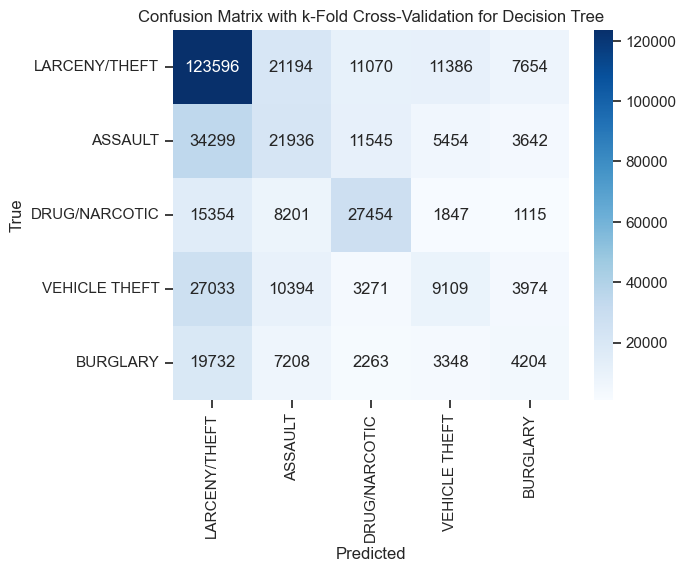

In [71]:
 #Konfusionsmatrix mit Seaborn dargestellt
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with k-Fold Cross-Validation for Decision Tree')
plt.show()

Interpretation der Ergebnisse: 



## Classification Report

Zum Abschluss wird der Classification Report scikit-learn-Paket genutzt, um eine Zusammenfassung der wichtigsten Klassifikationsmetriken für die Bewertung der Leistung des Entscheidungsbaums zu liefern. Der Report nimmt die wahren Klassenetiketten und die vorhergesagten Klassenetiketten als Eingabe und gibt Präzision, Recall, F1-Score und andere Metriken für jede Klasse sowie den gewichteten Durchschnitt dieser Metriken aus.

In [67]:
from sklearn.metrics import classification_report

report_tree = classification_report(y, y_pred)
print("Classification Report:\n", report_tree)


Classification Report:
                precision    recall  f1-score   support

      ASSAULT       0.32      0.29      0.30     76876
     BURGLARY       0.20      0.11      0.15     36755
DRUG/NARCOTIC       0.49      0.51      0.50     53971
LARCENY/THEFT       0.56      0.71      0.63    174900
VEHICLE THEFT       0.29      0.17      0.21     53781

     accuracy                           0.47    396283
    macro avg       0.37      0.36      0.36    396283
 weighted avg       0.44      0.47      0.45    396283


Interpretation der Ergebnisse: 



['LARCENY/THEFT', 'ASSAULT', 'DRUG/NARCOTIC', 'VEHICLE THEFT', 'BURGLARY']

## Feature Importance

Feature Importance:
_PdDistrict_BAYVIEW: 0.005482179504116032
_PdDistrict_CENTRAL: 0.022381028237263578
_PdDistrict_INGLESIDE: 0.006386922334647187
_PdDistrict_MISSION: 0.0006186813643026215
_PdDistrict_NORTHERN: 0.02583153550865321
_PdDistrict_PARK: 0.0052612077192553345
_PdDistrict_RICHMOND: 0.0008590613828650282
_PdDistrict_SOUTHERN: 0.024536672064034853
_PdDistrict_TARAVAL: 0.001059291017342054
_PdDistrict_TENDERLOIN: 0.001246585903563646
_TimeOfDay_00: 0.011702943108647572
_TimeOfDay_01: 0.013028885053576671
_TimeOfDay_02: 0.01410760027798609
_TimeOfDay_03: 0.012211972511991662
_TimeOfDay_04: 0.009548433438659491
_TimeOfDay_05: 0.009186696756701336
_TimeOfDay_06: 0.008708662806949055
_TimeOfDay_07: 0.009983767804825338
_TimeOfDay_08: 0.010002088858901534
_TimeOfDay_09: 0.010441063992204921
_TimeOfDay_10: 0.012004568927297905
_TimeOfDay_11: 0.012174763642439313
_TimeOfDay_12: 0.012646382591697534
_TimeOfDay_13: 0.012230792697943822
_TimeOfDay_14: 0.012246091712087495
_TimeOfDay_15:

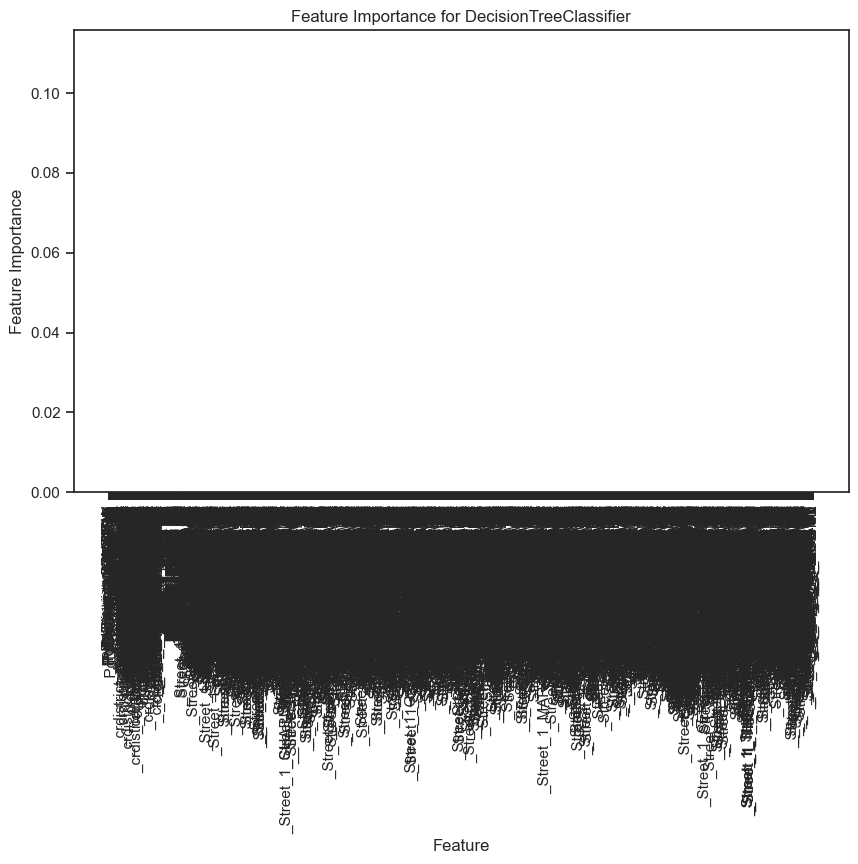

In [76]:
import matplotlib.pyplot as plt

model = DecisionTreeClassifier()
model.fit(X,y)

feature_importance = model.feature_importances_

# Namen der Features
print("Feature Importance:")
for i in range(len(feature_importance)):
    print(f"{X.columns[i]}: {feature_importance[i]}")



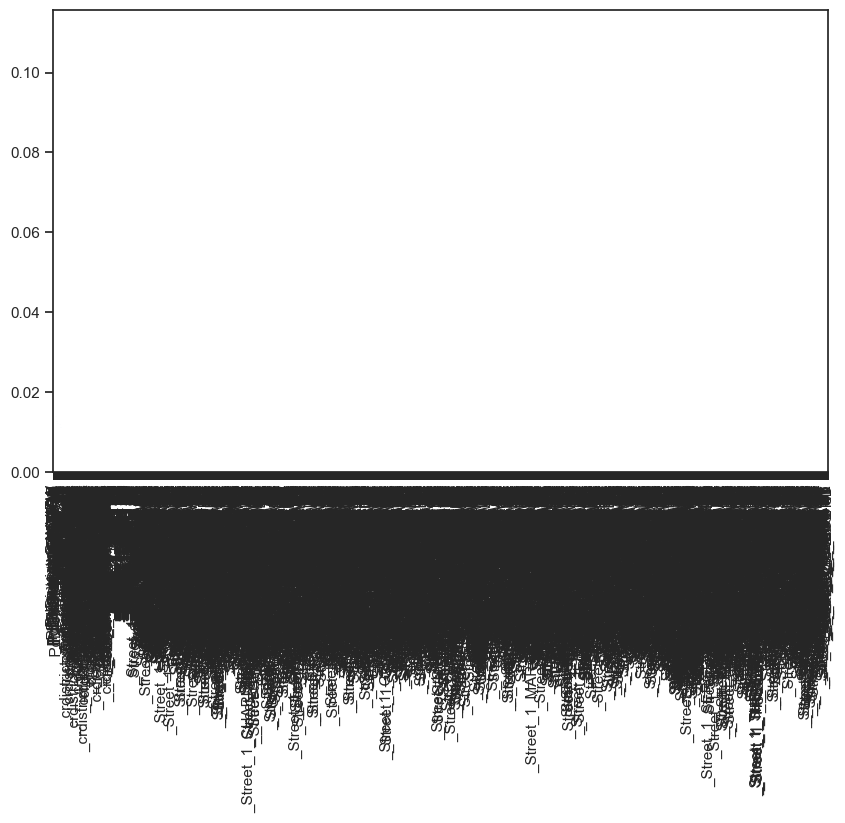

In [106]:
plt.figure(figsize=(10, 6))
plt.bar(range(0,20,1), feature_importance[::-1][0:20])
# plt.xticks(range(len(feature_importance)), X.columns, rotation=90)
# plt.xlabel("Feature")
# plt.ylabel("Feature Importance")
# plt.title("Feature Importance for DecisionTreeClassifier")
plt.show()

In [104]:
feature_importance[::-1]



array([0.1102012 , 0.02583154, 0.02489963, ..., 0.        , 0.        ,
       0.        ])

# II. Quellen

- Pappas, Yannis. "SF Crime Analysis & Prediction." Kaggle, https://www.kaggle.com/code/yannisp/sf-crime-analysis-prediction.
- Chawla, N. V., Bowyer, K. W., Hall, L. O. & Kegelmeyer, W. P. (2002). SMOTE: Synthetic Minority Over-sampling technique. Journal Of Artificial Intelligence Research, 16, 321–357. https://doi.org/10.1613/jair.953
- City and County of San Francisco. (2016). SF Find Neighborhoods. [Dataset]. Socrata. https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4
- Cramér, H. (1946). Mathematical Methods of Statistics. Princeton: Princeton University Press, p. 282 (Chapter 21. The two-dimensional case). ISBN 0-691-08004-6.
- "RandomizedSearchCV. (s.d.). Scikit-learn Documentation." https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
- "GridSearchCV. (s.d.). Scikit-learn Documentation." https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html